# Predicting Semantic Changes in Tweets in Response to Natural Disasters

In this Jupyter notebook, we'll explore the application of deep learning to predict semantic changes in Twitter data in response to natural disasters. This notebook forms part of a larger project that investigates how attributes of tweets, specifically 'aggressiveness', 'sentiment', and 'stance', are affected by natural disasters.

We have prepared datasets in which each instance corresponds to a specific geographic pixel and a particular natural disaster event. Each instance has a label indicating whether the attribute under consideration has experienced a significant positive change, a significant negative change, or no significant change in the time frame surrounding the disaster event. However, to simplify our task, we have decided to convert this into a binary classification problem where we predict whether the change is positive or negative, ignoring instances with no significant change.

We are going to employ a Fully Connected Neural Network, also known as a Dense Network.

### Hyperparameters

The architecture of our model is defined as follows:

- The input layer size is equal to the number of features in our dataset.
- We use several hidden layers with sizes 64, 128, 256, 512, 256, 128, 64 consecutively.
- The output layer size is 1, as we are performing binary classification.

The choice of the number of layers and the number of units per layer is usually problem-specific and often requires some trial and error. In our case, we have chosen a model of medium complexity. We start with a lower number of neurons for the first hidden layer and gradually increase the number of neurons to allow the model to learn more complex representations. After reaching the peak at 512, we decrease the number of neurons gradually.

The activation function used in our hidden layers is the Rectified Linear Unit (ReLU), a widely used activation function that helps mitigate the vanishing gradients problem. In our output layer, we use the sigmoid activation function as it is suitable for binary classification problems, outputting a probability that the change is positive.

We train our models using the Adam optimization algorithm and the binary cross-entropy loss function, both standard choices for binary classification problems. We use a batch size of 64 and train for 100 epochs.

It's important to note that hyperparameters such as the number of layers, the number of units per layer, and the number of epochs are usually determined through cross-validation. However, due to the large amount of data and the high computational cost of training our deep learning models, we have opted for a reasonable starting point for these hyperparameters. In future work, we could fine-tune these hyperparameters to potentially achieve better performance.

For each of the three attributes ('aggressiveness', 'sentiment', 'stance'), we create and evaluate models using 16 different training datasets. Each dataset corresponds to a different combination of the number of days before and after a natural disaster event. This gives us a total of 48 models. By comparing the performances of these models, we aim to understand how the time window around a natural disaster event affects the predictability of changes in tweet attributes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import os

In [2]:
# Check for GPU availability
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass

In [3]:
# Define the parameters
resolution = 2
attributes = ['aggressiveness', 'sentiment', 'stance']
days_before_after = [7, 14, 21, 28]
metrics_df = pd.DataFrame(columns=['Attribute', 'Days Before', 'Days After', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

In [ ]:
# Loop over each attribute and each combination of days before and after
for attribute in attributes:
    for days_before in days_before_after:
        for days_after in days_before_after:
            # Load the data
            df = pd.read_csv(f'training_data_{resolution}deg/training_data_{resolution}deg_{attribute}_{days_before}db_{days_after}da.csv')

            # Exclude 'no_change' instances
            df = df[df['no_change'] != 1]

            # Separate features and target variables
            X = df.drop(['negative_change', 'no_change', 'positive_change'], axis=1)
            y = df['positive_change'] # Now y directly corresponds to whether there is a positive change or not

            # Normalize the features to [0, 1] range
            scaler = MinMaxScaler()
            X = scaler.fit_transform(X)

            # Split the data into training, validation and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

            # Define the model
            model = Sequential()
            model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
            model.add(Dense(128, activation='relu'))
            model.add(Dense(256, activation='relu'))
            model.add(Dense(512, activation='relu'))
            model.add(Dense(256, activation='relu'))
            model.add(Dense(128, activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(1, activation='sigmoid')) # Changed to sigmoid activation

            # Compile the model
            model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy']) # Change the loss to binary_crossentropy

            # Train the model
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64)

            # Save the model
            save_model(model, f'models_{resolution}deg/model_{resolution}deg_{attribute}_{days_before}db_{days_after}da.h5')

            # Predict on test data
            y_pred = model.predict(X_test)
            y_pred = [1 if p >= 0.5 else 0 for p in y_pred]

            # Calculate performance metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            # Append to the dataframe
            new_row = pd.DataFrame({
                'Attribute': [attribute],
                'Days Before': [days_before],
                'Days After': [days_after],
                'Accuracy': [accuracy],
                'Precision': [precision],
                'Recall': [recall],
                'F1 Score': [f1]
            })
            metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

In [ ]:
# Save the metrics to a csv file
metrics_df.to_csv(f'model_performance_metrics_{resolution}deg.csv', index=False)

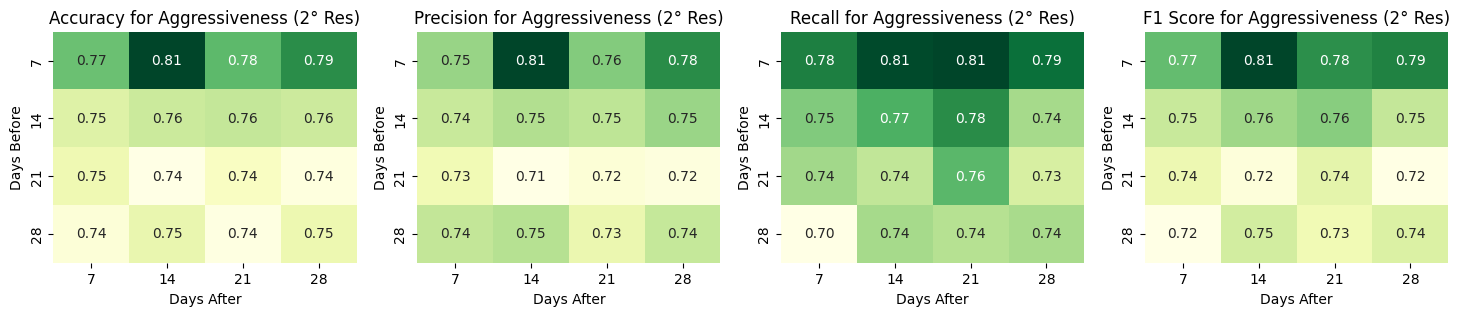

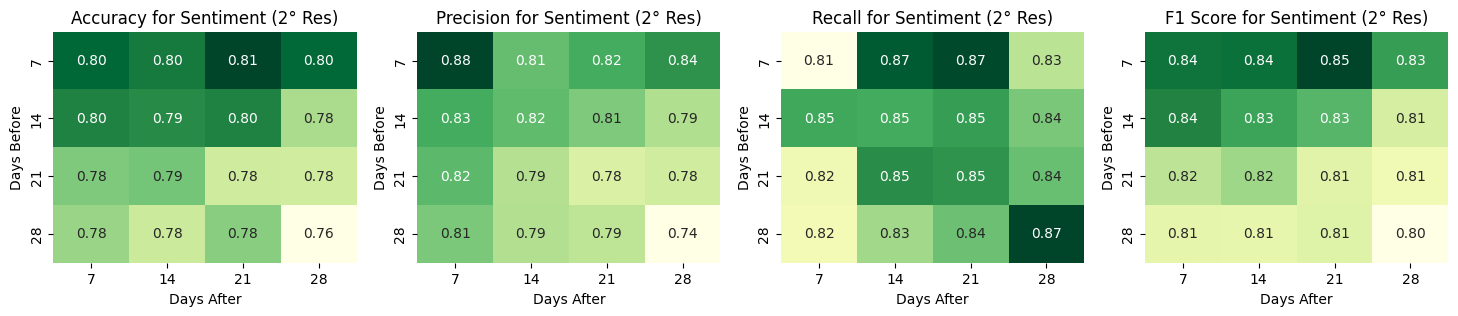

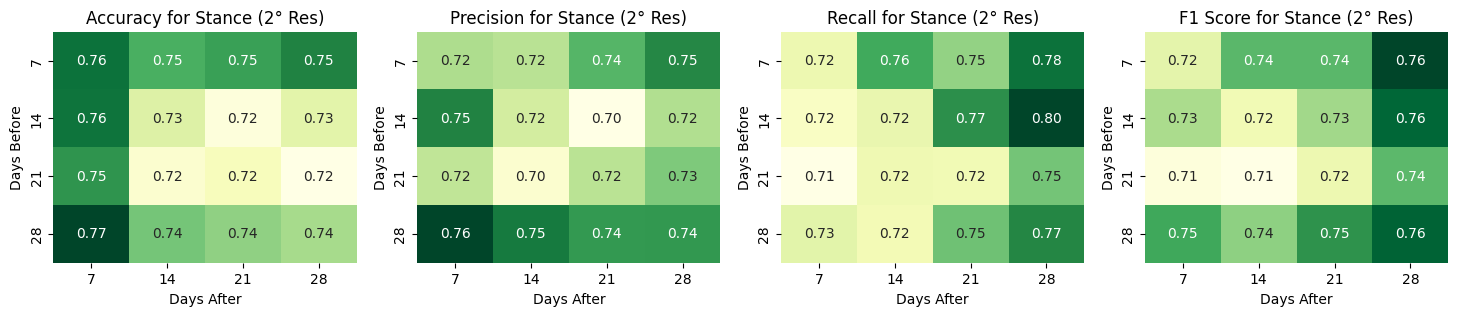

In [4]:
# Visualizing the performance
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

metrics_df = pd.read_csv(f'model_performance_metrics_{resolution}deg.csv')

for attribute in attributes:
    fig, axs = plt.subplots(1, 4, figsize=(18, 3))
    for i, metric in enumerate(metrics_list):
        attribute_metrics = metrics_df[metrics_df['Attribute'] == attribute].copy()
        attribute_metrics['Days Before'] = attribute_metrics['Days Before'].astype(int)
        attribute_metrics['Days After'] = attribute_metrics['Days After'].astype(int)
        pivoted_data = attribute_metrics.pivot(index='Days Before', columns='Days After', values=metric)
        sns.heatmap(pivoted_data, annot=True, cmap='YlGn', cbar=False, fmt=".2f", xticklabels=pivoted_data.columns, yticklabels=pivoted_data.index, ax=axs[i])
        axs[i].set_title(f'{metric} for {attribute.capitalize()} ({resolution}° Res)')
        axs[i].set_xlabel('Days After')
        axs[i].set_ylabel('Days Before')
    plt.show()

### Interpretation of the Results

The figures presented illustrate the performance metrics of our model predicting tweet 'aggressiveness', 'sentiment' and 'stance' in the 28 to 7-day period before and after a disaster. The y-axis displays the number of days leading up to a disaster, while the x-axis represents the number of days following a disaster, for which the data was examined.

Of all the semantic attributes considered, 'aggressiveness' appears to be the most influenced by the 'Days Before' parameter. Regardless of whether a 2° or 4° raster is used, the model's prediction performance tends to decline with an increase in 'Days Before'. Despite this, an accuracy level of around 0.77 indicates the model's successful identification of spatial patterns.
Intriguingly, the 'Days After' parameter seems to have a less pronounced impact on the model's performance. This may seem counterintuitive, given that one might expect the model's performance to decrease with an increase in the 'Days After' parameter, just as it does with the 'Days Before' parameter.

One potential explanation could be that 'aggressiveness' does not exhibit long-term trends, making it more challenging to predict based on spatial patterns. Alternatively, 'aggressiveness' may be influenced less by natural disasters and more by other events, such as political or societal happenings. These factors could obscure the spatial pattern, complicating the prediction process.

The second figure displays results for the prediction of 'sentiment'. With accuracy rates reaching up to 0.81, it can be inferred that the influence of natural disasters on tweet sentiment does follow spatial patterns. However, the model shows a relatively consistent decline in all performance measures as more 'Days After' an event are considered. This suggests that the impact of disasters on sentiment may be short-lived. Further support for this theory comes from the observation that the inclusion of more 'Days Before' in the prediction resulted in poorer model performance. This effect is particularly noticeable in the 4° prediction model.

Finally, the model's performance in predicting 'stance' is presented. With accuracy rates averaging around 0.74, it's clear that changes in stance also exhibit a spatial pattern. While accuracy and precision remain relatively constant across different 'Days After' variations, recall and the F1 score behave differently. This implies that the model had a higher number of false positives when predicting stance compared to models with more 'Days After'. Conversely, overall accuracy seems to increase when fewer 'Days After' are included. The reason behind this pattern isn't entirely clear given the current information but it could present an intriguing topic for further research.